<a href="https://colab.research.google.com/github/ApollineP/Group9/blob/master/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import warnings
warnings.filterwarnings('ignore')

import pandas as pd # load and manipulate data 
import numpy as np # calculate the mean and standard deviation of the data

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import xgboost as xgb 
from xgboost import plot_tree

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)

import sklearn.metrics as metrics
from sklearn.metrics import (
    balanced_accuracy_score, 
    roc_auc_score, 
    make_scorer, 
    roc_curve, 
    precision_recall_curve, 
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from diagnostics import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
filename = 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
df = pd.read_csv(filename,  header = 'infer')

## Creating XGBoost model using all features. 

XGBoost is able to identify itself the most relevant features. 

Before - 75.52  
After optimization - 75.57%  

In [ ]:
X = df.drop(['Diabetes_binary'], axis = 1).copy()
y = df['Diabetes_binary'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

## XGBoost classifier

XGBoost doesn't require pre-processing

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42)

clf_xgb.fit(X_train, 
            y_train,
            verbose=False,
            early_stopping_rounds=10, 
            eval_metric = 'aucpr',
            eval_set=[(X_val, y_val)])

print('AUC-PR score: ', clf_xgb.score(X_val, y_val))

AUC-PR score:  0.7450018860807243


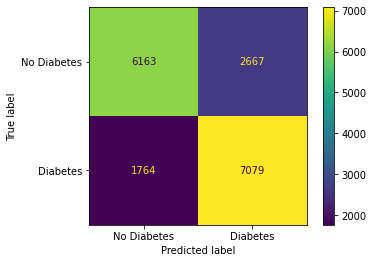

In [ ]:
# Display Confusion Matrix
y_pred = clf_xgb.predict(X_test)

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), 
                                     display_labels=['No Diabetes', 'Diabetes'])


conf_matrix.plot(include_values=True, xticks_rotation='horizontal')
plt.savefig('conf_matrix_xgb.png')


## Hyper-parameter tuning


In order to prevent overfitting and speed up cross-validation, an individual tree uses only 90% of the data and 50% of the columns.



In [ ]:
# Round 1
# {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 1.0}
# Round 2
# {'gamma': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 5}
# Round 3
# {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 3}
# Round 4
# {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 4}
# Round 5
# {'gamma': 1.5, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 4}
# Round 6 - add reg_alpha - 1 to 5
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 2} - 85% subsample
# Round 7
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 1} - 90% subsample
# Round 8
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 1} - 85% subsample

param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'learning_rate': [0.1, 0.2],
    'gamma': [0.5, 1, 1.5, 2],
    'reg_alpha' : [1, 2, 3, 4],
    'reg_lambda': [1, 2, 3, 4],
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective = 'binary:logistic', 
                                seed = 42,
                                subsample = 0.85,
                                colsample_bytree = 0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=False,
    n_jobs=10, 
    cv=5
)

optimal_params.fit(X_train, 
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='auc',
                   verbose=False,
                   eval_set=[(X_val, y_val)])

print(optimal_params.best_params_)
print('AUC-PR score: ', optimal_params.score(X_val, y_val))

KeyboardInterrupt: ignored

# Model with optimized parameters

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 2} - 85% subsample -> 75.57%

In [ ]:
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 2} - 85% subsample -> 75.57%
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 1} - 90% subsample -> 75.42%
# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 2, 'reg_lambda': 1} - 85% subsample -> 75.53%

clf_xgb = xgb.XGBClassifier(seed = 42,
                           objective = 'binary:logistic', 
                           gamma = 1,
                           learning_rate = 0.1, 
                           max_depth = 5, 
                           reg_alpha = 3, 
                           reg_lambda = 2,
                           subsample = 0.85, 
                           colsample_bytree = 0.5)

clf_xgb.fit(X_train, 
            y_train,
            verbose=False,
            early_stopping_rounds=10, 
            eval_metric = 'aucpr',
            eval_set=[(X_val, y_val)])

print('AUC-PR score: ', clf_xgb.score(X_val, y_val))
print('AUC-PR score: ', clf_xgb.score(X_test, y_test))

AUC-PR score:  0.7504715201810638
AUC-PR score:  0.7530696542748826


# ROC curve 

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.savefig('roc_xgb.png')
plt.show()



# MCC-F1 Curve

Best Threshold=0.490, G-Mean=0.752


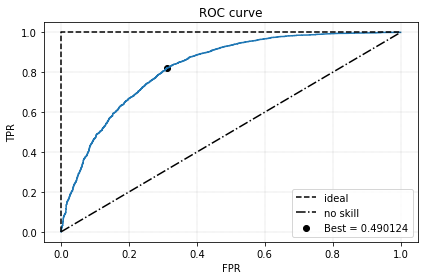

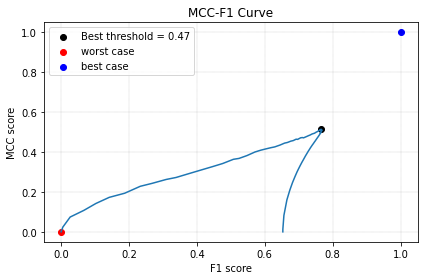

In [ ]:
y_score = clf_xgb.predict_proba(X_val)[:,1]
roc_threshold = roc(y_score, y_val, save_path="roc_xgb")
mcc_threshold = f1_mcc(y_score, y_val, save_path="mcc_f1_xgb")


# Probability distribution

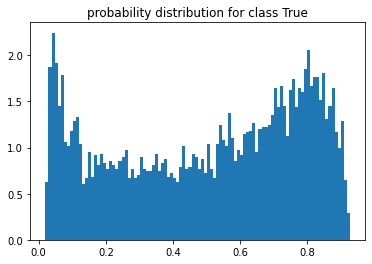

In [ ]:
probability_dist(y_score, save_path="prob_dist_xgb")

# Adjust threshold

In [ ]:
def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    # plt.savefig('youden_threshold_xgb.png')
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    # plt.savefig('threshold_xgb.png')
    plt.show()

In [ ]:
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

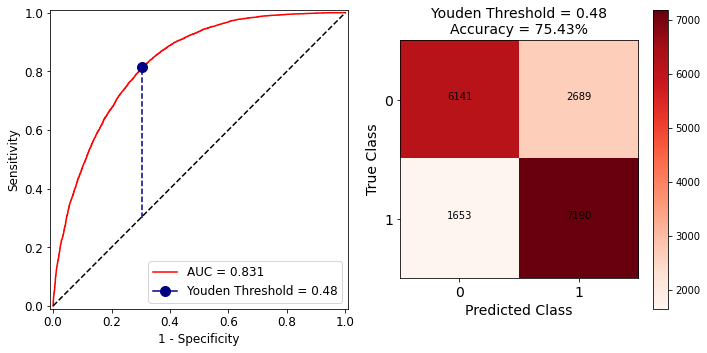

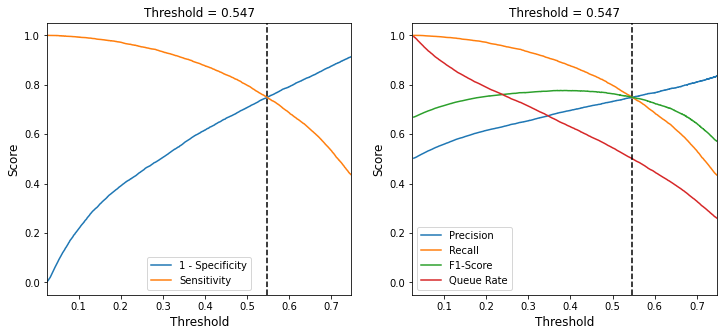

In [ ]:
_threshold_finder(model = clf_xgb, X = X_test, y_true = y_test)

0.7490522265602897


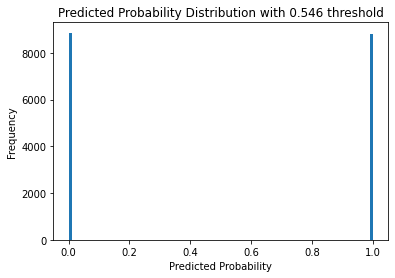

In [ ]:
y_pred_new_threshold = (clf_xgb.predict_proba(X_test)[:,1]>=0.549).astype(int)
print(accuracy_score(y_test, y_pred_new_threshold))
plt.hist(y_pred_new_threshold, bins=100)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Predicted Probability Distribution with 0.546 threshold')
plt.savefig('prob_dist_threshold_xgb.png')
plt.show()

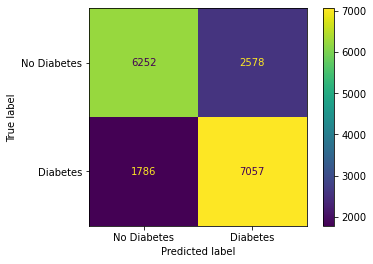

In [ ]:
# Display Confusion Matrix
y_pred = clf_xgb.predict(X_test)

conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), 
                                     display_labels=['No Diabetes', 'Diabetes'])


conf_matrix.plot(include_values=True, xticks_rotation='horizontal')



Precision: 0.732
Recall: 0.798
F1 score: 0.764
MCC score: 0.508
Accuracy: 0.753


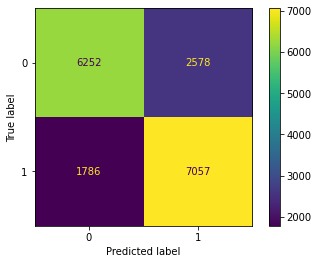



Precision: 0.729
Recall: 0.807
F1 score: 0.766
MCC score: 0.509
Accuracy: 0.753


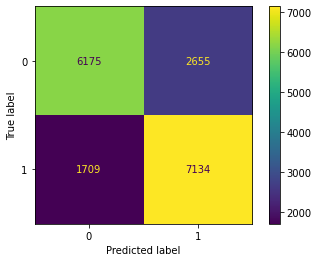



Precision: 0.721
Recall: 0.825
F1 score: 0.770
MCC score: 0.511
Accuracy: 0.753


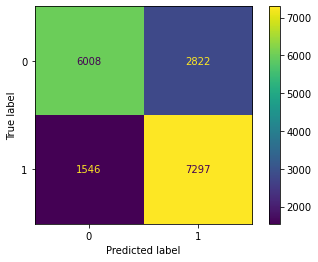



Precision: 0.725
Recall: 0.817
F1 score: 0.768
MCC score: 0.511
Accuracy: 0.754


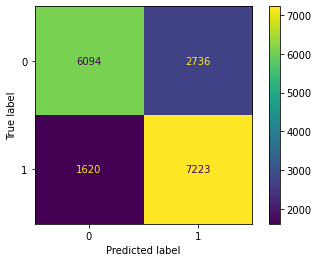

In [ ]:
def print_diagnostics(diags):
    print("\n")
    print("Precision: %1.3f" % diags[0])
    print("Recall: %1.3f" % diags[1])
    print("F1 score: %1.3f" % diags[2])
    print("MCC score: %1.3f" % diags[4])
    print("Accuracy: %1.3f" % diags[5])
    disp = ConfusionMatrixDisplay(confusion_matrix=diags[3])
    disp.plot()
    plt.show()
    
def get_diagnostics(pred, y_valid, threshold=0.5):
    """returns all evaluation metrics"""
    y_pred = [int(x > threshold) for i, x in enumerate(pred)]

    diags = (
        precision_score(y_valid, y_pred),
        recall_score(y_valid, y_pred),
        f1_score(y_valid, y_pred),
        confusion_matrix(y_valid, y_pred),
        matthews_corrcoef(y_valid, y_pred),
        accuracy_score(y_valid, y_pred),
    )
    print_diagnostics(diags)
prediction_test = clf_xgb.predict_proba(X_test)[:,1]
get_diagnostics(prediction_test, y_test, 0.5)
get_diagnostics(prediction_test, y_test, roc_threshold)
get_diagnostics(prediction_test, y_test, mcc_threshold)
get_diagnostics(prediction_test, y_test, (mcc_threshold+roc_threshold)/2)

## Visualization

In [ ]:
clf_xgb = xgb.XGBClassifier(
                           objective = 'binary:logistic', 
                           gamma = 1,
                           learning_rate = 0.1, 
                           max_depth = 5, 
                           reg_alpha = 3, 
                           reg_lambda = 2,
                           subsample = 0.85, 
                           colsample_bytree = 0.5,
                           n_estimators=1)

clf_xgb.fit(X_train, y_train)

print('AUC-PR score: ', clf_xgb.score(X_test, y_test))

In [ ]:
plot_tree(clf_xgb, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(120, 120)
fig.savefig('tree.png')